### Exogenous Variables

\begin{align*}
&A(t) = \text{level of technology} \\
&(Lt) = \text{labor inputs} \\
&(Lt) = \text{population at time i, also equal to labor inputs} \\
&i = \text{time} \\
\end{align*}

### Parameters

\begin{align*}
&a = \text{rate of inequality aversion} \\
&b,, be = \text{parameters of emissions-reduction cost function} \\
&ß = \text{marginal atmospheric retention ratio of GHG} \\
&y = \text{elasticity of output with respect to capital} \\
&8x = \text{rate of depreciation of the capital stock} \\
&öm = \text{rate of transfer of GHGs from upper to lower reservoir} \\
&2 = \text{feedback parameter in climate model} \\
&p = \text{pure rate of social time preference} \\
&R, = \text{thermal capacity of the upper layer} \\
&R, = \text{thermal parameters of deep oceans} \\
&• (t) = \text{emissions/output ratio} \\
&T12 = \text{transfer rate from lower to upper reservoir} \\
&8, 0, = \text{parameters of damage function} \\
\end{align*}

### Endogenous Variables

\begin{align*}
&C(t) = \text{consumption} \\
&c(t) = \text{per capita consumption} \\
&d(t) = \text{damage from greenhouse warming} \\
&E(t) = \text{emissions of greenhouse gases} \\
&F(t) = \text{radiative forcing from GHGs} \\
&Q(t) = \text{output reduction due to emissions controls and to damages from climate change} \\
&K(t) = \text{capital stock} \\
&M(t) = \text{mass of greenhouse gases in atmosphere} \\
&Q(t) = \text{gross world product} \\
&T(t) = \text{atmospheric temperature relative to base period} \\
&T°(t) = \text{deep-ocean temperature relative to base period} \\
&TC(t) = \text{total cost of reducing GHG emissions} \\
&u(t) = uct)] = \text{utility of per capita consumption} \\
\end{align*}

### Policy Variables

\begin{align*}
&1(t) = gross investment \\
&N(t) = rate of emissions reduction
\end{align*}

### Initial Values of Parameters

\begin{align*}
    &a =0 \\
    &b, =.0686 \\
    &b2 =2.887 \\
    &B =64 \\
    &y=25 \\
    &8k = .10 \text{ per year} \\
    &8m = .0833 \text{ per decade} \\
    &8a =-1.1 \text{ percent per year} \\
    &8 pop = -19.5 \text{ percent per decade} \\
    &8pop 1965) = 2.03 \text{ percent per year} \\
    &gA (1965) = 1.14 \text{ percent per year} \\
    &Bo = -1.25 \text{ percent per year} \\
    &K(1965) = 16.0 \text{ trillion U. S. dollars, 1989 prices} \\
    &2 = 1.41 \text{ degrees C/W-m?} \\
    &M(1960) = 677 \text{ billion tons CO, equivalent, carbon weight} \\
    &L(1965) = 3.369 \text{ billion persons} \\
    &p = .03 \text{ per year} \\
    &1/R, = .226 \text{ C-'/watt-years} \\
    &R,/T12 = 44 \text{ watts/•C-m'} \\
    &Q(1965) = 8.519 \text{ trillion U. S. dollars, 1989 prices} \\
    &0 (t) =5368 \text{ (98751-1999)} \\
    &T(1960) = .2 \text{ degrees C} \\
    &T* (1960) = .1 \text{ degrees C} \\
    &0, = .00144 \\
    &0, =2 \\
\end{align*}


In [1]:
import seaborn as sns
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import scipy.optimize as opt
from matplotlib.ticker import EngFormatter

class DICE():

    def __init__(self):
        self.time_step = 5  # Years per Period
        # Set
        self.min_year = 2000
        self.max_year = 2500
        self.TT = np.linspace(
            self.min_year, self.max_year, 100, dtype=np.int32)
        self.NT = len(self.TT)
        self.t = np.arange(1, self.NT+1)

    def init_parameters(self, a3=2.00, prstp=0.015, elasmu=1.45):

        # Maximum cumulative extraction fossil fuels (GtC); denoted by CCum
        self.fosslim = 6000
        self.ifopt = 0  # Indicator where optimized is 1 and base is 0
        self.elasmu = elasmu  # Elasticity of marginal utility of consumption
        self.prstp = prstp  # Initial rate of social time preference per year

        self.init_pop_and_tech_parameters()
        self.init_emissions_parameters()
        self.init_carboncycle_parameters()
        self.init_climatemodel_parameters()
        self.init_climatedamage_parameters(a3)
        self.init_abatementcost_parameters()

        # ** Scaling and inessential parameters
        # * Note that these are unnecessary for the calculations
        # * They ensure that MU of first period's consumption =1 and PV cons = PV utilty
        # Multiplicative scaling coefficient /0.0302455265681763 /
        self.scale1 = 0.0302455265681763
        self.scale2 = -10993.704  # Additive scaling coefficient       /-10993.704/;

        # * carbon cycling coupling matrix
        self.b11 = 1 - self.b12
        self.b21 = self.b12*self.mateq/self.mueq
        self.b22 = 1 - self.b21 - self.b23
        self.b32 = self.b23*self.mueq/self.mleq
        self.b33 = 1 - self.b32

        # * Further definitions of parameters
        self.a20 = self.a2
        self.sig0 = self.e0/(self.q0*(1-self.miu0))  # From Eq. 14
        self.lam = self.fco22x / self.t2xco2  # From Eq. 25

        self.init_exogeneous_inputs()

    def init_pop_and_tech_parameters(self, gama=0.300, pop0=7403, popadj=0.134,
                                     popasym=11500, dk=0.100, q0=105.5,
                                     k0=223, a0=5.115, ga0=0.076, dela=0.005):
        self.gama = gama  # Capital elasticity in production function         /.300 /
        # Initial world population 2015 (millions)          /7403 /
        self.pop0 = pop0
        self.popadj = popadj  # Growth rate to calibrate to 2050 pop projection  /0.134/
        # Asymptotic population (millions)                 /11500/
        self.popasym = popasym
        # Depreciation rate on capital (per year)           /.100 /
        self.dk = dk
        # Initial world gross output 2015 (trill 2010 USD) /105.5/
        self.q0 = q0
        # Initial capital value 2015 (trill 2010 USD)        /223  /
        self.k0 = k0
        self.a0 = a0  # Initial level of total factor productivity       /5.115/
        self.ga0 = ga0  # Initial growth rate for TFP per 5 years          /0.076/
        self.dela = dela  # Decline rate of TFP per 5 years                  /0.005/

    # ** Emissions parameters
    def init_emissions_parameters(self, gsigma1=-0.0152, dsig=-0.001, eland0=2.6,
                                  deland=0.115, e0=35.85, miu0=0.03):
        # Initial growth of sigma (per year)            /-0.0152/
        self.gsigma1 = gsigma1
        # Decline rate of decarbonization (per period)    /-0.001 /
        self.dsig = dsig
        # Carbon emissions from land 2015 (GtCO2 per year)   / 2.6   /
        self.eland0 = eland0
        # Decline rate of land emissions (per period)        / .115  /
        self.deland = deland
        # Industrial emissions 2015 (GtCO2 per year)       /35.85  /
        self.e0 = e0
        self.miu0 = miu0  # Initial emissions control rate for base case 2015  /.03    /

    # ** Carbon cycle
    def init_carboncycle_parameters(self, mat0=851, mu0=460, ml0=1740, mateq=588, mueq=360, mleq=1720):
        # * Initial Conditions
        # Initial Concentration in atmosphere 2015 (GtC)       /851  /
        self.mat0 = mat0
        # Initial Concentration in upper strata 2015 (GtC)     /460  /
        self.mu0 = mu0
        # Initial Concentration in lower strata 2015 (GtC)    /1740 /
        self.ml0 = ml0
        # mateq Equilibrium concentration atmosphere  (GtC)    /588  /
        self.mateq = mateq
        # mueq Equilibrium concentration in upper strata (GtC) /360  /
        self.mueq = mueq
        # mleq Equilibrium concentration in lower strata (GtC) /1720 /
        self.mleq = mleq

        # * Flow paramaters, denoted by Phi_ij in the model
        self.b12 = 0.12  # Carbon cycle transition matrix                     /.12  /
        self.b23 = 0.007  # Carbon cycle transition matrix                    /0.007/
        # * These are for declaration and are defined later
        self.b11 = None   # Carbon cycle transition matrix
        self.b21 = None  # Carbon cycle transition matrix
        self.b22 = None  # Carbon cycle transition matrix
        self.b32 = None  # Carbon cycle transition matrix
        self.b33 = None  # Carbon cycle transition matrix
        # Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)
        self.sig0 = None

    # ** Climate model parameters
    def init_climatemodel_parameters(self):
        # Equilibrium temp impact (oC per doubling CO2)    / 3.1 /
        self.t2xco2 = 3.1
        # 2015 forcings of non-CO2 GHG (Wm-2)              / 0.5 /
        self.fex0 = 0.5
        # 2100 forcings of non-CO2 GHG (Wm-2)              / 1.0 /
        self.fex1 = 1.0
        # Initial lower stratum temp change (C from 1900) /.0068/
        self.tocean0 = 0.0068
        # Initial atmospheric temp change (C from 1900)    /0.85/
        self.tatm0 = 0.85
        self.c1 = 0.1005  # Climate equation coefficient for upper level  /0.1005/
        self.c3 = 0.088  # Transfer coefficient upper to lower stratum    /0.088/
        self.c4 = 0.025  # Transfer coefficient for lower level           /0.025/
        # eta in the model; Eq.22 : Forcings of equilibrium CO2 doubling (Wm-2)   /3.6813 /
        self.fco22x = 3.6813

    def init_climatedamage_parameters(self, a3=2.00):
        # ** Climate damage parameters
        self.a10 = 0  # Initial damage intercept                         /0   /
        self.a20 = None  # Initial damage quadratic term
        self.a1 = 0  # Damage intercept                                 /0   /
        self.a2 = 0.00236  # Damage quadratic term                     /0.00236/
        self.a3 = a3  # Damage exponent                              /2.00   /

    def init_abatementcost_parameters(self):
        # ** Abatement cost
        # Theta2 in the model, Eq. 10 Exponent of control cost function             / 2.6  /
        self.expcost2 = 2.6
        self.pback = 550  # Cost of backstop 2010$ per tCO2 2015          / 550  /
        self.gback = 0.025  # Initial cost decline backstop cost per period / .025/
        self.limmiu = 1.2  # Upper limit on control rate after 2150        / 1.2 /
        self.tnopol = 45  # Period before which no emissions controls base  / 45   /
        # Initial base carbon price (2010$ per tCO2)      / 2    /
        self.cprice0 = 2
        self.gcprice = 0.02  # Growth rate of base carbon price per year     /.02

    def init_exogeneous_inputs(self):
        NT = self.NT

        self.l = np.zeros(NT)
        self.l[0] = self.pop0  # Labor force
        self.al = np.zeros(NT)
        self.al[0] = self.a0
        self.gsig = np.zeros(NT)
        self.gsig[0] = self.gsigma1
        self.sigma = np.zeros(NT)
        self.sigma[0] = self.sig0
        # TFP growth rate dynamics, Eq. 7
        self.ga = self.ga0 * np.exp(-self.dela*5*(self.t-1))
        self.pbacktime = self.pback * \
            (1-self.gback)**(self.t-1)  # Backstop price
        # Emissions from deforestration
        self.etree = self.eland0*(1-self.deland)**(self.t-1)
        self.rr = 1/((1+self.prstp)**(self.time_step*(self.t-1)))  # Eq. 3
        # The following three equations define the exogenous radiative forcing; used in Eq. 23
        self.forcoth = np.full(NT, self.fex0)
        self.forcoth[0:18] = self.forcoth[0:18] + \
            (1/17)*(self.fex1-self.fex0)*(self.t[0:18]-1)
        self.forcoth[18:NT] = self.forcoth[18:NT] + (self.fex1-self.fex0)
        # Optimal long-run savings rate used for transversality (Question)
        self.optlrsav = (self.dk + .004)/(self.dk + .004 *
                                          self.elasmu + self.prstp)*self.gama
        self.cost1 = np.zeros(NT)
        self.cumetree = np.zeros(NT)
        self.cumetree[0] = 100
        self.cpricebase = self.cprice0*(1+self.gcprice)**(5*(self.t-1))

    def InitializeLabor(self, il, iNT):
        for i in range(1, iNT):
            il[i] = il[i-1]*(self.popasym / il[i-1])**self.popadj

    def InitializeTFP(self, ial, iNT):
        for i in range(1, iNT):
            ial[i] = ial[i-1]/(1-self.ga[i-1])

    def InitializeGrowthSigma(self, igsig, iNT):
        for i in range(1, iNT):
            igsig[i] = igsig[i-1]*((1+self.dsig)**self.time_step)

    def InitializeSigma(self, isigma, igsig, icost1, iNT):
        for i in range(1, iNT):
            isigma[i] = isigma[i-1] * np.exp(igsig[i-1] * self.time_step)
            icost1[i] = self.pbacktime[i] * isigma[i] / self.expcost2 / 1000

    def InitializeCarbonTree(self, icumetree, iNT):
        for i in range(1, iNT):
            icumetree[i] = icumetree[i-1] + self.etree[i-1]*(5/3.666)

    """
    Emissions of carbon and weather damages
    """

    # Retuns the total carbon emissions; Eq. 18
    def fE(self, iEIND, index):
        return iEIND[index] + self.etree[index]

    # Eq.14: Determines the emission of carbon by industry EIND
    def fEIND(self, iYGROSS, iMIU, isigma, index):
        return isigma[index] * iYGROSS[index] * (1 - iMIU[index])

    # Cumulative industrial emission of carbon
    def fCCA(self, iCCA, iEIND, index):
        return iCCA[index-1] + iEIND[index-1] * 5 / 3.666

    # Cumulative total carbon emission
    def fCCATOT(self, iCCA, icumetree, index):
        return iCCA[index] + icumetree[index]

    # Eq. 22: the dynamics of the radiative forcing
    def fFORC(self, iMAT, index):
        return self.fco22x * np.log(iMAT[index]/588.000)/np.log(2) + self.forcoth[index]

    # Dynamics of Omega; Eq.9
    def fDAMFRAC(self, iTATM, index):
        return self.a1*iTATM[index] + self.a2*iTATM[index]**self.a3

    # Calculate damages as a function of Gross industrial production; Eq.8
    def fDAMAGES(self, iYGROSS, iDAMFRAC, index):
        return iYGROSS[index] * iDAMFRAC[index]

    # Dynamics of Lambda; Eq. 10 - cost of the reudction of carbon emission (Abatement cost)
    def fABATECOST(self, iYGROSS, iMIU, icost1, index):
        return iYGROSS[index] * icost1[index] * iMIU[index]**self.expcost2

    # Marginal Abatement cost
    def fMCABATE(self, iMIU, index):
        return self.pbacktime[index] * iMIU[index]**(self.expcost2-1)

    # Price of carbon reduction
    def fCPRICE(self, iMIU, index):
        return self.pbacktime[index] * (iMIU[index])**(self.expcost2-1)

    # Eq. 19: Dynamics of the carbon concentration in the atmosphere
    def fMAT(self, iMAT, iMU, iE, index):
        if (index == 0):
            return self.mat0
        else:
            return iMAT[index-1]*self.b11 + iMU[index-1]*self.b21 + iE[index-1] * 5 / 3.666

    # Eq. 21: Dynamics of the carbon concentration in the ocean LOW level
    def fML(self, iML, iMU, index):
        if (index == 0):
            return self.ml0
        else:
            return iML[index-1] * self.b33 + iMU[index-1] * self.b23

    # Eq. 20: Dynamics of the carbon concentration in the ocean UP level
    def fMU(self, iMAT, iMU, iML, index):
        if (index == 0):
            return self.mu0
        else:
            return iMAT[index-1]*self.b12 + iMU[index-1]*self.b22 + iML[index-1]*self.b32

    # Eq. 23: Dynamics of the atmospheric temperature
    def fTATM(self, iTATM, iFORC, iTOCEAN, index):
        if (index == 0):
            return self.tatm0
        else:
            return iTATM[index-1] + self.c1 * (iFORC[index] - (self.fco22x/self.t2xco2) * iTATM[index-1] - self.c3 * (iTATM[index-1] - iTOCEAN[index-1]))

    # Eq. 24: Dynamics of the ocean temperature
    def fTOCEAN(self, iTATM, iTOCEAN, index):
        if (index == 0):
            return self.tocean0
        else:
            return iTOCEAN[index-1] + self.c4 * (iTATM[index-1] - iTOCEAN[index-1])

    """
    economic variables
    """

    # The total production without climate losses denoted previously by YGROSS
    def fYGROSS(self, ial, il, iK, index):
        return ial[index] * ((il[index]/1000)**(1-self.gama)) * iK[index]**self.gama

    # The production under the climate damages cost
    def fYNET(self, iYGROSS, iDAMFRAC, index):
        return iYGROSS[index] * (1 - iDAMFRAC[index])

    # Production after abatement cost
    def fY(self, iYNET, iABATECOST, index):
        return iYNET[index] - iABATECOST[index]

    # Consumption Eq. 11
    def fC(self, iY, iI, index):
        return iY[index] - iI[index]

    # Per capita consumption, Eq. 12
    def fCPC(self, iC, il, index):
        return 1000 * iC[index] / il[index]

    # Saving policy: investment
    def fI(self, iS, iY, index):
        return iS[index] * iY[index]

    # Capital dynamics Eq. 13
    def fK(self, iK, iI, index):
        if (index == 0):
            return self.k0
        else:
            return (1-self.dk)**self.time_step * iK[index-1] + self.time_step * iI[index-1]

    # Interest rate equation; Eq. 26 added in personal notes
    def fRI(self, iCPC, index):
        return (1 + self.prstp) * (iCPC[index+1]/iCPC[index])**(self.elasmu/self.time_step) - 1

    # Periodic utility: A form of Eq. 2
    def fCEMUTOTPER(self, iPERIODU, il, index):
        return iPERIODU[index] * il[index] * self.rr[index]

    # The term between brackets in Eq. 2
    def fPERIODU(self, iC, il, index):
        return ((iC[index]*1000/il[index])**(1-self.elasmu) - 1) / (1 - self.elasmu) - 1

    # utility function
    def fUTILITY(self, iCEMUTOTPER, resUtility):
        resUtility[0] = self.time_step * self.scale1 * \
            np.sum(iCEMUTOTPER) + self.scale2

    def init_variables(self): # TODO: add full variable names as comments
        NT = self.NT
        self.K = np.zeros(NT)       
        self.YGROSS = np.zeros(NT)
        self.EIND = np.zeros(NT)
        self.E = np.zeros(NT)
        self.CCA = np.zeros(NT)
        self.CCATOT = np.zeros(NT)
        self.MAT = np.zeros(NT)
        self.ML = np.zeros(NT)
        self.MU = np.zeros(NT)
        self.FORC = np.zeros(NT)
        self.TATM = np.zeros(NT)
        self.TOCEAN = np.zeros(NT)
        self.DAMFRAC = np.zeros(NT)
        self.DAMAGES = np.zeros(NT)
        self.ABATECOST = np.zeros(NT)
        self.MCABATE = np.zeros(NT)
        self.CPRICE = np.zeros(NT)
        self.YNET = np.zeros(NT)
        self.Y = np.zeros(NT)
        self.I = np.zeros(NT)
        self.C = np.zeros(NT)
        self.CPC = np.zeros(NT)
        self.RI = np.zeros(NT)
        self.PERIODU = np.zeros(NT)
        self.CEMUTOTPER = np.zeros(NT)

        self.optimal_controls = np.zeros(2*NT)

        self.InitializeLabor(self.l, NT)
        self.InitializeTFP(self.al, NT)
        self.InitializeGrowthSigma(self.gsig, NT)
        self.InitializeSigma(self.sigma, self.gsig, self.cost1, NT)
        self.InitializeCarbonTree(self.cumetree, NT)

    def get_control_bounds_and_startvalue(self):

        NT = self.NT
        # * Control variable limits
        MIU_lo = np.full(NT, 0.01)
        MIU_up = np.full(NT, self.limmiu)
        MIU_up[0:29] = 1
        MIU_lo[0] = self.miu0
        MIU_up[0] = self.miu0
        MIU_lo[MIU_lo == MIU_up] = 0.99999*MIU_lo[MIU_lo == MIU_up]
        bnds1 = []
        for i in range(NT):
            bnds1.append((MIU_lo[i], MIU_up[i]))

        lag10 = np.arange(1, NT+1) > NT - 10
        S_lo = np.full(NT, 1e-1)
        S_lo[lag10] = self.optlrsav
        S_up = np.full(NT, 0.9)
        S_up[lag10] = self.optlrsav
        S_lo[S_lo == S_up] = 0.99999*S_lo[S_lo == S_up]
        bnds2 = []
        for i in range(NT):
            bnds2.append((S_lo[i], S_up[i]))
        bnds = bnds1 + bnds2

        # starting values for the control variables:
        S_start = np.full(NT, 0.2)
        S_start[S_start < S_lo] = S_lo[S_start < S_lo]
        S_start[S_start > S_up] = S_lo[S_start > S_up]
        MIU_start = 0.99*MIU_up
        MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
        MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]
        x_start = np.concatenate([MIU_start, S_start])

        return x_start, bnds

    def fOBJ(self, controls):
        self.roll_out(controls)
        resUtility = np.zeros(1)
        self.fUTILITY(self.CEMUTOTPER, resUtility)

        return -1*resUtility[0]

    def roll_out(self, controls):
        NT = self.NT

        iMIU = controls[0:NT]
        iS = controls[NT:(2*NT)]

        for i in range(NT):
            self.K[i] = self.fK(self.K, self.I, i)
            self.YGROSS[i] = self.fYGROSS(self.al, self.l, self.K, i)
            self.EIND[i] = self.fEIND(self.YGROSS, iMIU, self.sigma, i)
            self.E[i] = self.fE(self.EIND, i)
            self.CCA[i] = self.fCCA(self.CCA, self.EIND, i)
            self.CCATOT[i] = self.fCCATOT(self.CCA, self.cumetree, i)
            self.MAT[i] = self.fMAT(self.MAT, self.MU, self.E, i)
            self.ML[i] = self.fML(self.ML, self.MU, i)
            self.MU[i] = self.fMU(self.MAT, self.MU, self.ML, i)
            self.FORC[i] = self.fFORC(self.MAT, i)
            self.TATM[i] = self.fTATM(self.TATM, self.FORC, self.TOCEAN, i)
            self.TOCEAN[i] = self.fTOCEAN(self.TATM, self.TOCEAN, i)
            self.DAMFRAC[i] = self.fDAMFRAC(self.TATM, i)
            self.DAMAGES[i] = self.fDAMAGES(self.YGROSS, self.DAMFRAC, i)
            self.ABATECOST[i] = self.fABATECOST(
                self.YGROSS, iMIU, self.cost1, i)
            self.MCABATE[i] = self.fMCABATE(iMIU, i)
            self.CPRICE[i] = self.fCPRICE(iMIU, i)
            self.YNET[i] = self.fYNET(self.YGROSS, self.DAMFRAC, i)
            self.Y[i] = self.fY(self.YNET, self.ABATECOST, i)
            self.I[i] = self.fI(iS, self.Y, i)
            self.C[i] = self.fC(self.Y, self.I, i)
            self.CPC[i] = self.fCPC(self.C, self.l, i)
            self.PERIODU[i] = self.fPERIODU(self.C, self.l, i)
            self.CEMUTOTPER[i] = self.fCEMUTOTPER(self.PERIODU, self.l, i)
#             self.RI[i] = self.fRI(self.CPC, i)

    def optimize_controls(self, controls_start, controls_bounds):
        result = opt.minimize(self.fOBJ, controls_start, method='SLSQP', bounds=tuple(
            controls_bounds), options={'disp': True})
        self.optimal_controls = result.x
        return result

    def plot_run(self, title_str):
        Tmax = 2150
        NT = self.NT
        variables = [self.optimal_controls[NT:(2*NT)], self.optimal_controls[0:NT], self.CPRICE, self.EIND, self.TATM, self.DAMAGES, self.MAT,
                     self.E]
        variables = [var[self.TT < Tmax] for var in variables]
        variable_labels = ["Saving rate",
                           "Em rate",  # 'Carbon emission control rate'
                           "carbon price",
                           "INdustrial emissions",
                           # Increase temperature of the atmosphere (TATM)
                           "Degrees C from 1900",
                           "Damages",  # 'trillions 2010 USD per year'
                           "GtC from 1750",  # 'Carbon concentration increase in the atmosphere'
                           "GtCO2 per year"  # Total CO2 emission
                           ]
        variable_limits = [[0, 0.5], [0, 1], [0, 400], [-20, 40],
                           [0, 5], [0, 150], [0, 1500],  [-20, 50]]  # y axis ranges
        plot_world_variables(self.TT[self.TT < Tmax], variables, variable_labels, variable_limits,
                             title=title_str,figsize=[4+len(variables), 7],
                             grid=True)


def plot_world_variables(time, var_data, var_names, var_lims,
                         title=None,
                         figsize=None,
                         dist_spines=0.09,
                         grid=False):
    prop_cycle = pl.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    var_number = len(var_data)

    fig, host = pl.subplots(figsize=figsize)
    axs = [host, ]
    for i in range(var_number-1):
        axs.append(host.twinx())

    fig.subplots_adjust(left=dist_spines*2)
    for i, ax in enumerate(axs[1:]):
        ax.spines["left"].set_position(("axes", -(i + 1)*dist_spines))
        ax.spines["left"].set_visible(True)
        ax.yaxis.set_label_position('left')
        ax.yaxis.set_ticks_position('left')

    ps = []
    for ax, label, ydata, color in zip(axs, var_names, var_data, colors):
        ps.append(ax.plot(time, ydata, label=label,
                          color=color, clip_on=False)[0])
    axs[0].grid(grid)
    axs[0].set_xlim(time[0], time[-1])

    for ax, lim in zip(axs, var_lims):
        ax.set_ylim(lim[0], lim[1])

    for axit, ax_ in enumerate(axs):
        ax_.tick_params(axis='y', rotation=90)
        ax_.yaxis.set_major_locator(pl.MaxNLocator(5))
        formatter_ = EngFormatter(places=0, sep="\N{THIN SPACE}")
        ax_.yaxis.set_major_formatter(formatter_)

    tkw = dict(size=4, width=1.5)
    axs[0].set_xlabel("time [years]")
    axs[0].tick_params(axis='x', **tkw)
    for i, (ax, p) in enumerate(zip(axs, ps)):
        ax.set_ylabel(p.get_label(), rotation=25)
        ax.yaxis.label.set_color(p.get_color())
        ax.tick_params(axis='y', colors=p.get_color(), **tkw)
        ax.yaxis.set_label_coords(-i*dist_spines, 1.01)
    axs[0].set_title(title)


def hello_world():
    dice = DICE()
    dice.init_parameters()
    dice.init_variables()
    controls_start, controls_bounds = dice.get_control_bounds_and_startvalue()
    dice.optimize_controls(controls_start, controls_bounds)
    dice.roll_out(dice.optimal_controls)
    dice.plot_run("Hello World Scenario")

## Analysis

In [2]:
dice_std = DICE()  # create an instance of the model
dice_std.init_parameters()
dice_std.init_variables()
controls_start_std, controls_bounds_std = dice_std.get_control_bounds_and_startvalue()
dice_std.optimize_controls(controls_start_std, controls_bounds_std);

/Users/danypineault/anaconda3/envs/IAM-Book/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318954614702
            Iterations: 95
            Function evaluations: 19230
            Gradient evaluations: 95


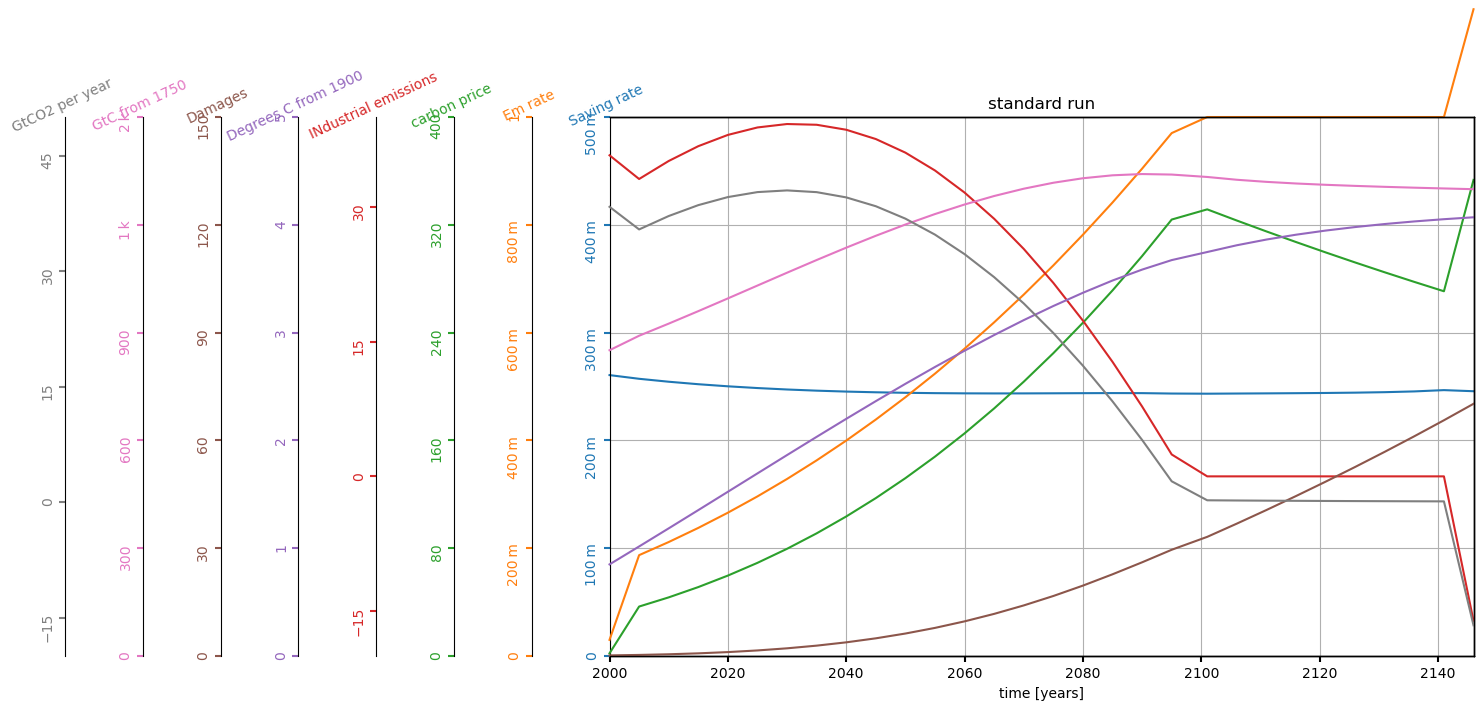

In [3]:
dice_std.roll_out(dice_std.optimal_controls)
dice_std.plot_run("standard run")

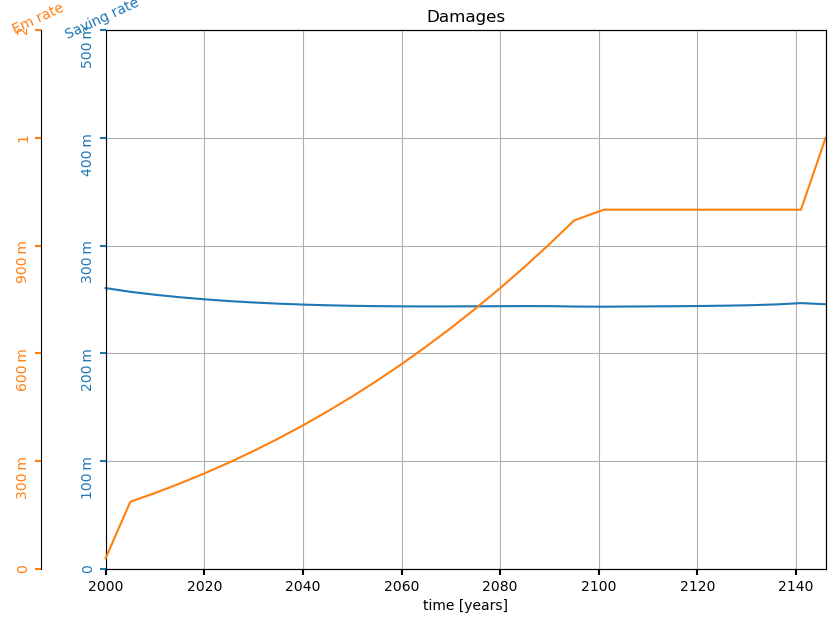

In [4]:
vars_ = [dice_std.optimal_controls[dice_std.NT:(2*dice_std.NT)], dice_std.optimal_controls[0:dice_std.NT], dice_std.CPRICE, dice_std.EIND, dice_std.TATM, dice_std.DAMAGES, dice_std.MAT, dice_std.E]
names_ = [
    "Saving rate",
    "Em rate",
    "carbon price",
    "INdustrial emissions",
    "Degrees C from 1900",
    "Damages",
    "GtC from 1750",
    "GtCO2 per year"
]
lims_ = [[0, 0.5], [0, 1.5], [0, 400], [-20, 40], [0, 5], [0, 150], [0, 1500],  [-20, 50]]
Tmax = 2150

idx = [0,1]

vars = [vars_[0], vars_[1]]
names = [names_[0], names_[1]]
lims = [lims_[0], lims_[1]]

vars = [var[dice_std.TT < Tmax] for var in vars]
time = dice_std.TT[dice_std.TT < Tmax]

plot_world_variables(time , vars, names, lims, title="Damages", figsize=[8+len(vars), 7], grid=True)

### Damage Functions

NameError: name 'dice' is not defined

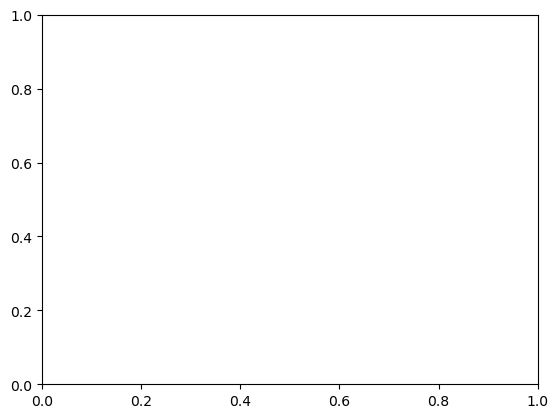

In [5]:
fig, ax = pl.subplots()
T = np.linspace(0, 4, 1000)
for a1 in [0.00236, 0.01, 0.1]:
    dice.a2 = a1
    ax.plot(
        T,
        dice.fDAMFRAC([T], 0),
        label=r"$a_1=" + str(a1) + "$" + ("(DICE2023)" if a1 == a1DICE else ""),
    )
    
ax.legend(frameon=False)
ax.set_xlabel("temperature change, $\Delta T$")
ax.set_ylabel("fraction productivity destroyed")
ax.set_ylim(0, 0.5)

NameError: name 'dicelib' is not defined